## Preparation

In [1]:
%cd ../..
import pandas as pd
import experiment.preprocess as preprocess
from candidates_generation import triple_gen
import importlib
import numpy as np

/Users/fieng/Project/KGC_RAG


/Users/fieng/Project/KGC_RAG/langchain-env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
path ='data/codex-m/data_sample.csv'
df = pd.read_csv(path)
evaluation_df, candidates_df, missing_df = preprocess.create_experiment_df(path)

/Users/fieng/Project/KGC_RAG/experiment/preprocess.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_cand_df['Missing'] = 1
/Users/fieng/Project/KGC_RAG/experiment/preprocess.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_cand_df['Missing'] = 0


In [3]:
import experiment.filtering as filtering

filtred_df = filtering.create_filtred_df(df, evaluation_df, missing_df)

/Users/fieng/Project/KGC_RAG/langchain-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: fieng. Use `wandb login --relogin` to force relogin


No cuda devices were available. The model runs on CPU
Training epochs on cpu: 100%|██████████| 50/50 [04:30<00:00,  5.40s/epoch, loss=0.456, prev_loss=0.457]
Evaluating on cpu:   0%|          | 0.00/50.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 50.0/50.0 [00:00<00:00, 105triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.65s seconds


loss,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
testing.both.optimistic.adjusted_arithmetic_mean_rank,▁
testing.both.optimistic.adjusted_arithmetic_mean_rank_index,▁
testing.both.optimistic.adjusted_geometric_mean_rank_index,▁
testing.both.optimistic.adjusted_hits_at_k,▁
testing.both.optimistic.adjusted_inverse_harmonic_mean_rank,▁
testing.both.optimistic.arithmetic_mean_rank,▁
testing.both.optimistic.count,▁
testing.both.optimistic.geometric_mean_rank,▁
testing.both.optimistic.harmonic_mean_rank,▁
testing.both.optimistic.hits_at_1,▁


In [4]:
filtred_df = filtred_df.merge(evaluation_df, how='left')
true_cand_df = filtred_df[filtred_df['Missing'] == 1].sample(250)
false_cand_df = filtred_df[filtred_df['Missing'] == 0].sample(250)
filtred_df_sample = pd.concat([true_cand_df, false_cand_df])
filtred_df_sample = filtred_df_sample.sample(frac=1)

In [5]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_experimental.text_splitter import SemanticChunker
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.llms import Ollama

In [6]:
loader = CSVLoader(file_path=path)
docs = loader.load()
text_splitter = SemanticChunker(HuggingFaceEmbeddings())
documents = text_splitter.split_documents(docs)
# Instantiate the embedding model
embedder = HuggingFaceEmbeddings()
# Create the vector store 
vector = FAISS.from_documents(documents, embedder)


retriever = vector.as_retriever(search_type="similarity", search_kwargs={"k": 2})
# Define llm
llm = Ollama(model="mistral", temperature=0.1)

/var/folders/_3/wtwzgv1d3rlfz233qkf36kg00000gp/T/ipykernel_74077/2656201252.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  text_splitter = SemanticChunker(HuggingFaceEmbeddings())
/var/folders/_3/wtwzgv1d3rlfz233qkf36kg00000gp/T/ipykernel_74077/2656201252.py:3: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  text_splitter = SemanticChunker(HuggingFaceEmbeddings())
/var/folders/_3/wtwzgv1d3rlfz233qkf36kg00000gp/T/ipykernel_74077/2656201252.py:6: LangChainDeprecationWarning

In [22]:
type(retriever)

langchain_core.vectorstores.base.VectorStoreRetriever

In [7]:
from langchain.chains import RetrievalQA
from langchain.chains.llm import LLMChain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate

## Evaluation method

In [8]:
def triple2sentence(head,relation,tail):
    template = """
    1. Your job is only to translate triple into sentence, no matter if it is correct or not
    2. A triple is two entities (head and tail) linked by a relation
    3. Transform the following triples into a sentence: 'head: {head}, relation: {relation}, tail: {tail}'
    4. If the triple present incorrect fact, still translate this as it is
    5. Do not make negative sentence 
    Answer: Give the sentence."""

    prompt = ChatPromptTemplate.from_template(template)
    model = llm
    chain = prompt | model

    sentence = chain.invoke({"head": head,
                "relation": relation,
                'tail': tail}
                )
   
    return sentence

In [9]:
sentence_list = []
for item in filtred_df_sample.iterrows():
    triple = item[1]
    head = triple['Head']
    relation = triple['Relation']
    tail = triple['Tail']
    sentence = triple2sentence(head,relation,tail)
    sentence_list.append(sentence)

In [10]:
def eval_sentence(sentence):
    template = """
    1. Evaluate if the sentence represent a correct fact or not.\n
    2. Is the triple correct: answer "1" if it is correct and "0" otherwise.\n
    3. If you don't know the answer, just say that "-1"\n
    4. Start the answer with 'Score:'\n

    Sentence: {sentence}

    Helpful Answer:"""
    prompt = ChatPromptTemplate.from_template(template)
    model = llm
    chain = prompt | model

    answer = chain.invoke({"sentence":sentence})
   
    return answer

In [11]:
score_list = []
for sentence in sentence_list:
    score = eval_sentence(sentence)
    score_list.append(score)

## Result

In [12]:
def clean_score(list_score) -> list[float]:
    list_score = [item.rstrip('.') if item.endswith('.') else item for item in list_score]
    list_score = [0 if item == '' else item for item in list_score]
    score_bin = [1 if item == '1'  else 0 for item in list_score]
    return score_bin


def extract_score(text:str)->str:
    # Function to extract score
    # Find the starting index of "Score: "
    start_index = text.find("Score: ") + len("Score: ")

    # Find the end of the number, which could be marked by a non-digit character
    end_index = start_index
    while end_index < len(text) and (text[end_index].isdigit() or text[end_index] == '.'):
        end_index += 1

    # Extract and return the number using slicing
    return text[start_index:end_index]

In [13]:
new_score_list = [extract_score(score) for score in score_list]
new_score_list = clean_score(new_score_list)

In [14]:
filtred_df_sample['Pred'] = new_score_list

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def compute_score(prediction, ground_truth):
    cm = confusion_matrix(ground_truth, prediction)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    f1_score = (2 * TP) / (2 * TP + FP + FN)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    return accuracy, f1_score, recall, precision

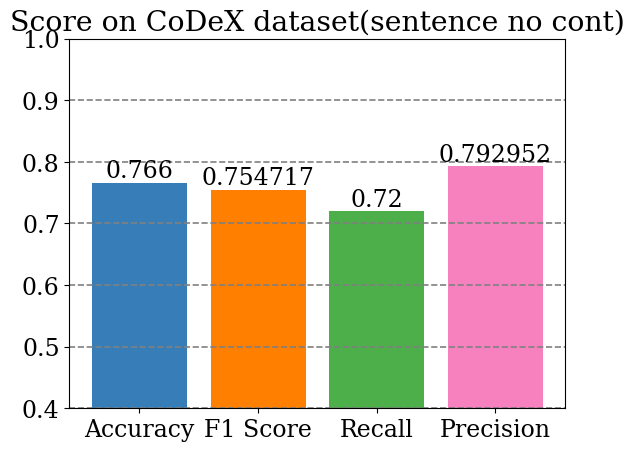

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 

ground_truth = filtred_df_sample['Missing']
prediction = filtred_df_sample['Pred']
accuracy, f1_score, recall, precision = compute_score(prediction, ground_truth)
scores = [accuracy, f1_score, recall, precision]
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
labels = ['Accuracy', 'F1 Score', 'Recall', 'Precision']
# setup family font
plt.rc('font', family='serif',size=17)
fig, ax = plt.subplots()
bars = ax.bar(labels, scores , label=labels, color=colors[:4])
# Set y-limit to center data
ax.set_ylim(0.4,1)

# Add legend with title
#ax.legend(title='Different methods', fontsize = 15, loc=2)
# Add gridlines (only on the y-axis)
ax.grid(linewidth=1.2, linestyle='--', axis='y', color='grey')
ax.set_title('Score on CoDeX dataset(sentence no cont)')
ax.bar_label(bars)
#plt.show()
plt.savefig('results/codex_m_sent_no_context.png')

In [24]:
print(f'Accuracy {accuracy:.2f}\nPrecision:{precision:.2f}\nRecall:{recall:.2f}\nF1:{f1_score:.2f}')

Accuracy 0.77
Precision:0.79
Recall:0.72
F1:0.75


In [18]:
sentence_df = filtred_df_sample.copy()

In [19]:
sentence_df['sentence'] = sentence_list

In [20]:
sentence_df.to_csv('sentence_to_eval.csv')